In [1]:
import random
import torch
from typing import Tuple
import triton
import pandas as pd
from fp8 import DeepLinear, quant_input, quant_weight
from copy import deepcopy
import os
os.environ['TRITON_PRINT_AUTOTUNING']= '1'
from tqdm import tqdm
from transformers import Trainer

/sharedata/mdy/miniforge/envs/cuda128/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 精度

In [ ]:
device = 'cuda'
dtype = torch.bfloat16
m, n, k = 4096 * 2, 8192, 8192
x1 = torch.randn(m, k, dtype=dtype, device=device)
x1.requires_grad_(True)
x2 = deepcopy(x1)
fc1 = torch.nn.Linear(k,n, bias=False, dtype=dtype, device=device)
fc2 = DeepLinear(k,n, bias=False, dtype=dtype, device=device)
fc2.weight.data.copy_(fc1.weight.data)
# dy = torch.randn(m, n, dtype=dtype, device=device)

In [5]:
y1 = fc1(x1)
y2 = fc2(x2)
dy = torch.randn_like(y1)
y1.backward(dy)
y2.backward(dy)
print(y1)
print(y2)
print(x1.grad)
print(x2.grad)
print(fc1.weight.grad)
print(fc2.weight.grad)

tensor([[-0.0786, -0.0291, -0.0059,  ..., -0.1719,  0.6562,  0.6992],
        [-0.3613,  0.1260, -0.2295,  ...,  0.9102, -0.8164, -0.6523],
        [-0.5781, -0.0552, -0.0029,  ...,  0.0583, -0.8516,  1.7109],
        ...,
        [-0.1719, -1.0391, -0.2305,  ..., -0.2520,  0.6719,  0.1377],
        [ 0.5664, -0.1875,  0.5547,  ...,  0.3242,  0.8242, -0.1816],
        [-0.9805,  0.1250, -0.1504,  ...,  0.4199, -0.2295, -0.3906]],
       device='cuda:0', dtype=torch.bfloat16, grad_fn=<MmBackward0>)
tensor([[-0.0583, -0.0248, -0.0031,  ..., -0.1729,  0.6953,  0.6641],
        [-0.3789,  0.1196, -0.2217,  ...,  0.8867, -0.8203, -0.6406],
        [-0.5742, -0.0649,  0.0026,  ...,  0.0444, -0.8320,  1.7188],
        ...,
        [-0.1689, -1.0703, -0.1953,  ..., -0.2656,  0.6836,  0.1396],
        [ 0.5977, -0.2031,  0.5742,  ...,  0.3203,  0.8359, -0.1846],
        [-0.9688,  0.1719, -0.0986,  ...,  0.4492, -0.2480, -0.4160]],
       device='cuda:0', dtype=torch.bfloat16, grad_fn=<_DeepLin

In [ ]:
print(triton.testing.do_bench(lambda: fc1(x1).backward(dy)))
# 可以把weight cache起来，第一个micro_bs去更新fp8_weight，可以去megatron_scrips中查看
print(triton.testing.do_bench(lambda: fc2(x2).backward(dy)) - triton.testing.do_bench(lambda: quant_weight(fc2.weight.data, only_forward=False)))


4.789308547973633
3.1469065845012665


In [5]:
print(triton.testing.do_bench(lambda: fc1(x1)))
print(triton.testing.do_bench(lambda: fc2(x2)))
y1 = fc1(x1)
y2 = fc2(x2)
dy = torch.randn_like(y1)
print(triton.testing.do_bench(lambda: y1.backward(dy, retain_graph=True)))
print(triton.testing.do_bench(lambda: y2.backward(dy, retain_graph=True)))

1.624271035194397
1.1004228591918945
3.3067338466644287
2.1649904251098633


# Forward

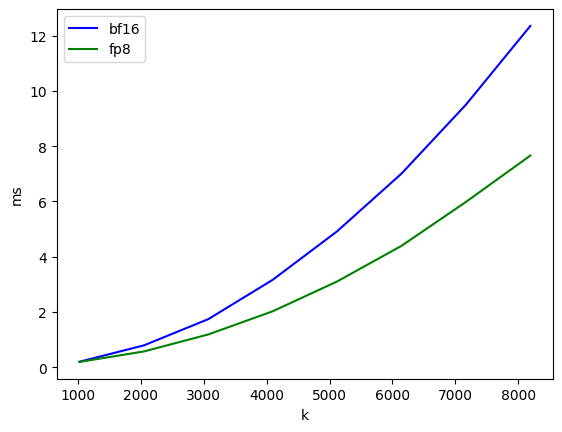

forward:
        k       bf16       fp8
0  1024.0   0.194941  0.188405
1  2048.0   0.786695  0.567100
2  3072.0   1.736629  1.182998
3  4096.0   3.160715  2.021425
4  5120.0   4.916526  3.100666
5  6144.0   7.006277  4.391098
6  7168.0   9.500768  5.980333
7  8192.0  12.351304  7.658754


In [2]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['k'],  # argument names to use as an x-axis for the plot
        x_vals=[1024 * i for i in range(1, 8+1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['bf16', 'fp8'],  # possible values for `line_arg``
        line_names=[
            "bf16",
            "fp8",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="forward",  # name for the plot. Used also as a file name for saving the plot.
        args={'m':4096, 'bs':4, 'factor':4},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(bs, m, k, factor, provider):
    n = k * factor
    device = 'cuda'
    dtype = torch.bfloat16
    x = torch.randn(bs*m, k, dtype=dtype, device=device) 
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'bf16':
        fc = torch.nn.Linear(k,n, bias=False, dtype=dtype, device=device)
        ms = triton.testing.do_bench(lambda: fc(x))
    if provider == 'fp8':
        fc = DeepLinear(k,n, bias=False, dtype=dtype, device=device)
        ms = triton.testing.do_bench(lambda: fc(x))
    return ms
benchmark.run(show_plots=True, print_data=True)

# Backward

/sharedata/mdy/miniforge/envs/cuda128/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


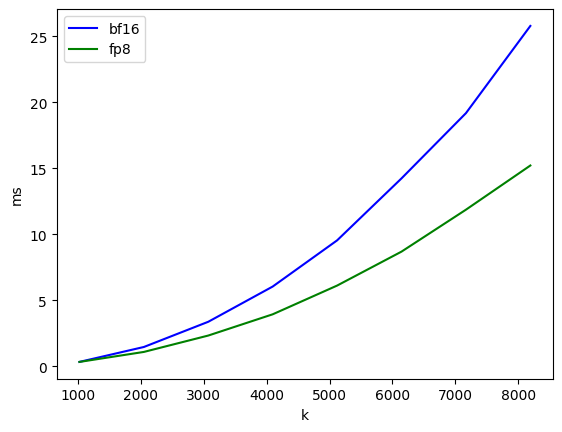

backward:
        k       bf16        fp8
0  1024.0   0.346827   0.344999
1  2048.0   1.475767   1.101843
2  3072.0   3.385527   2.342549
3  4096.0   6.052966   3.950739
4  5120.0   9.549991   6.126831
5  6144.0  14.244321   8.698150
6  7168.0  19.183290  11.872935
7  8192.0  25.788393  15.218900


In [3]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['k'],  # argument names to use as an x-axis for the plot
        x_vals=[1024 * i for i in range(1, 8+1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['bf16', 'fp8'],  # possible values for `line_arg``
        line_names=[
            "bf16",
            "fp8",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="backward",  # name for the plot. Used also as a file name for saving the plot.
        args={'m':4096, 'bs':4, 'factor':4},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(bs, m, k, factor, provider):
    n = k * factor
    device = 'cuda'
    dtype = torch.bfloat16
    x = torch.randn(bs*m, k, dtype=dtype, device=device)
    x.requires_grad_(True)
    
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'bf16':
        fc = torch.nn.Linear(k,n, bias=False, dtype=dtype, device=device)
        y = fc(x)
        dy = torch.rand_like(y)
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), grad_to_none=[x])
    if provider == 'fp8':
        fc = DeepLinear(k,n, bias=False, dtype=dtype, device=device)
        y = fc(x)
        dy = torch.rand_like(y)
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), grad_to_none=[x])
    return ms
benchmark.run(show_plots=True, print_data=True)